In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [2]:
df=pd.read_csv('Advertising1.csv')

In [3]:
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns='Newspaper',inplace=True)

In [4]:
df

,TV,Radio,Sales
0,230.1,37.8,22.1
1,44.5,39.3,10.4
2,17.2,45.9,9.3
3,151.5,41.3,18.5
4,180.8,10.8,12.9
...,...,...,...
195,38.2,3.7,7.6
196,94.2,4.9,9.7
197,177.0,9.3,12.8
198,283.6,42.0,25.5


## Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [6]:
y=df.Sales.copy()
df.drop(columns='Sales',inplace=True)

In [7]:
# Random 100 samples
# x_train,x_test,y_train,y_test = train_test_split(df,y,
#                                                  test_size=0.5,
#                                                  random_state=0)

In [8]:
# First 100 samples
x_train = df.iloc[0:100,:]
x_test = df.iloc[100:,:]
y_train = y[:100]
y_test = y[100:]

In [9]:
m1 = LinearRegression().fit(x_train,y_train)
y_train_pred = m1.predict(x_train)

In [57]:
m1.coef_

array([0.04585391, 0.18412361])

In [58]:
m1.intercept_

3.146986251809624

In [10]:
train_set=pd.DataFrame(x_train)
train_set['y']=y_train.values
train_set["Predict"]=y_train_pred

In [11]:
train_set['res']=train_set['y']-train_set["Predict"]

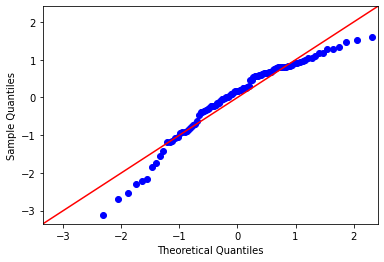

In [62]:
sm.qqplot(train_set['res'],fit=True, line="45")
plt.show()
plt.title()

<AxesSubplot:>

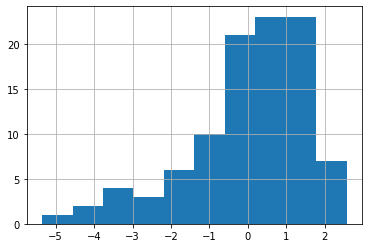

In [13]:
train_set['res'].hist()

In [14]:
pd.DataFrame(train_set['res'].sort_values())

,res
5,-5.349560
35,-4.431625
25,-3.846413
78,-3.599893
75,-3.268119
...,...
36,1.949990
60,2.131582
76,2.197433
55,2.336964


In [15]:
#remove outliers in training set
train_set = train_set.drop([5,91])

In [16]:
y_test_pred = m1.predict(x_test)
test_set=pd.DataFrame(x_test)
test_set['y']=y_test.values
test_set["Predict"]=y_test_pred

In [17]:
test_set['res']=test_set['y']-test_set["Predict"]

<AxesSubplot:>

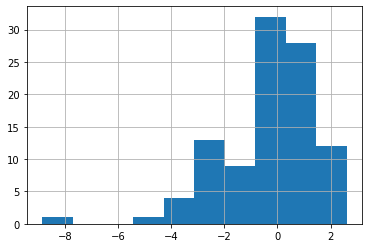

In [18]:
test_set['res'].hist()

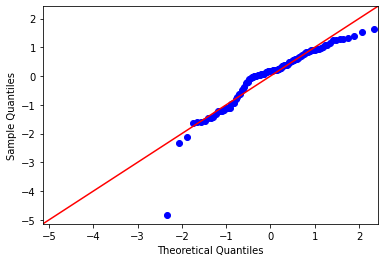

In [19]:
fig = sm.qqplot(test_set['res'],fit=True, line="45")
plt.show()

In [20]:
pd.DataFrame(test_set['res'].sort_values())

,res
130,-8.870379
178,-4.458248
126,-4.067055
158,-3.177638
131,-3.141402
...,...
195,2.020137
147,2.079285
175,2.152421
128,2.429340


In [21]:
#remove outliers in testing set
test_set = test_set.drop([130,128,117])

In [22]:
train_set

,TV,Radio,y,Predict,res
0,230.1,37.8,22.1,20.657844,1.442156
1,44.5,39.3,10.4,12.423543,-2.023543
2,17.2,45.9,9.3,12.386947,-3.086947
3,151.5,41.3,18.5,17.698159,0.801841
4,180.8,10.8,12.9,13.425909,-0.525909
...,...,...,...,...,...
95,163.3,31.6,16.9,16.453236,0.446764
96,197.6,3.5,11.7,12.852152,-1.152152
97,184.9,21.0,15.5,15.491971,0.008029
98,289.7,42.3,25.4,24.219294,1.180706


In [23]:
m2 = LinearRegression().fit(train_set[['TV','Radio']],train_set['y'])

In [24]:
from scipy import stats

In [25]:
m2.intercept_

3.0530461454173565

In [26]:
m2.coef_

array([0.04498936, 0.19427843])

In [27]:
beta0 = m2.intercept_
beta1 = m2.coef_[0]
beta2 = m2.coef_[1]

## Deterministic LP

In [28]:
L_x1 = min(train_set['TV'])
U_x1 = max(train_set['TV'])
L_x2 = min(train_set['Radio'])
U_x2 = max(train_set['Radio'])
x1_bounds = (L_x1, U_x1)
x2_bounds = (L_x2, U_x2)
bounds = [x1_bounds, x2_bounds]
print('x1 bounds:', bounds[0])
print('x2 bounds:', bounds[1])

x1 bounds: (5.4, 293.6)
x2 bounds: (1.4, 49.6)


In [29]:
# declare model
m_det = ConcreteModel()

# declare variables
def bounds_rule(m, i):
    return bounds[i-1]

m_det.x = Var([1,2], domain = NonNegativeReals, bounds = bounds_rule)

m_det.yA = Var(domain = NonNegativeReals)
m_det.yB = Var(domain = NonNegativeReals)

#Objective
m_det.obj = Objective(expr = -0.1*m_det.x[1]-0.5*m_det.x[2]+3*m_det.yA+5*m_det.yB, sense=maximize)

#Constraints
m_det.c1 = Constraint(expr = m_det.x[1]+m_det.x[2]<=200)
m_det.c2 = Constraint(expr = m_det.x[1]-0.5*m_det.x[2]>=0)
m_det.c3 = Constraint(expr = m_det.yA<=8)
m_det.c4 = Constraint(expr = m_det.yB<=12)
m_det.c5 = Constraint(expr = 3*m_det.yA+2*m_det.yB<=36)
m_det.c6 = Constraint(expr = -beta1*m_det.x[1]-beta2*m_det.x[2]+m_det.yA+m_det.yB<=beta0)

In [30]:
SolverFactory('glpk').solve(m_det)

{'Problem': [{'Name': 'unknown', 'Lower bound': 41.4189639878442, 'Upper bound': 41.4189639878442, 'Number of objectives': 1, 'Number of constraints': 7, 'Number of variables': 5, 'Number of nonzeros': 13, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.01555013656616211}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [31]:
x1_det = m_det.x.extract_values()[1]
x2_det = m_det.x.extract_values()[2]

In [32]:
print(x1_det,x2_det)

173.54740996961 26.4525900303895


In [33]:
m_det.obj()

41.41896398784425

In [34]:
test_set['Res_val']=y_test-beta0-beta1*x_test['TV']-beta2*x_test['Radio']
test_set['Demand_val']=beta0 + beta1*x1_det + beta2*x2_det + test_set['Res_val']

In [35]:
train_set = train_set.reset_index()
test_set = test_set.reset_index()

In [36]:
test_set

,index,TV,Radio,y,Predict,res,Res_val,Demand_val
0,100,222.4,4.3,11.7,14.136628,-2.436628,-2.194076,13.805924
1,101,296.4,36.3,23.8,23.421773,0.378227,0.359802,16.359802
2,102,280.2,10.1,14.8,17.854901,-3.054901,-2.821276,13.178724
3,103,187.9,17.2,14.7,14.929863,-0.229863,-0.148135,15.851865
4,104,238.2,34.3,20.7,20.384828,0.315172,0.266739,16.266739
...,...,...,...,...,...,...,...,...
92,195,38.2,3.7,7.6,5.579863,2.020137,2.109530,18.109530
93,196,94.2,4.9,9.7,8.368631,1.331369,1.456992,17.456992
94,197,177.0,9.3,12.8,12.975478,-0.175478,-0.022952,15.977048
95,198,283.6,42.0,25.5,23.884348,1.615652,1.528278,17.528278


In [37]:
train_set['Res_trn']=train_set['y']-beta0-beta1*train_set['TV']-beta2*train_set['Radio']

In [38]:
train_set

,index,TV,Radio,y,Predict,res,Res_trn
0,0,230.1,37.8,22.1,20.657844,1.442156,1.351178
1,1,44.5,39.3,10.4,12.423543,-2.023543,-2.290215
2,2,17.2,45.9,9.3,12.386947,-3.086947,-3.444243
3,3,151.5,41.3,18.5,17.698159,0.801841,0.607367
4,4,180.8,10.8,12.9,13.425909,-0.525909,-0.385329
...,...,...,...,...,...,...,...
93,95,163.3,31.6,16.9,16.453236,0.446764,0.360994
94,96,197.6,3.5,11.7,12.852152,-1.152152,-0.922917
95,97,184.9,21.0,15.5,15.491971,0.008029,0.048575
96,98,289.7,42.3,25.4,24.219294,1.180706,1.095560


# SLP with SAA

In [39]:
L_x1 = min(train_set['TV'])
U_x1 = max(train_set['TV'])
L_x2 = min(train_set['Radio'])
U_x2 = max(train_set['Radio'])
x1_bounds = (L_x1, U_x1)
x2_bounds = (L_x2, U_x2)
bounds = [x1_bounds, x2_bounds]
print('x1 bounds:', bounds[0])
print('x2 bounds:', bounds[1])

x1 bounds: (5.4, 293.6)
x2 bounds: (1.4, 49.6)


In [40]:
# declare model
N = train_set.shape[0]
error = train_set['Res_trn']
m_slp = ConcreteModel()
m_slp.idx = RangeSet(1,N)

# declare variables
def bounds_rule(m, i):
    return bounds[i-1]

m_slp.x = Var([1,2], domain = NonNegativeReals, bounds = bounds_rule)

m_slp.yA = Var(m_slp.idx, domain = NonNegativeReals)
m_slp.yB = Var(m_slp.idx, domain = NonNegativeReals)

#Objective
m_slp.obj = Objective(expr = -0.1*m_slp.x[1]-0.5*m_slp.x[2]+(1/N)*(
    sum(3*m_slp.yA[i]+5*m_slp.yB[i] for i in m_slp.idx)), sense=maximize)

#Constraints
m_slp.c1 = Constraint(expr = m_slp.x[1]+m_slp.x[2]<=200)
m_slp.c2 = Constraint(expr = m_slp.x[1]-0.5*m_slp.x[2]>=0)

def c3(m,i):
    return m.yA[i]<=8
m_slp.c3 = Constraint(m_slp.idx, rule=c3)

def c4(m,i):
    return m.yB[i]<=12
m_slp.c4 = Constraint(m_slp.idx, rule=c4)

def c5(m,i):
    return 3*m.yA[i]+2*m.yB[i]<=36
m_slp.c5 = Constraint(m_slp.idx, rule=c5)


def c6(m,i):
    return -beta1*m.x[1]-beta2*m.x[2]+m.yA[i]+m.yB[i]<= beta0 + error[i-1]
m_slp.c6 = Constraint(m_slp.idx, rule=c6)

SolverFactory('glpk').solve(m_slp)

#slp_result[str(N)] = [m_slp.obj(), m_slp.x.extract_values()[1],m_slp.x.extract_values()[2]]

{'Problem': [{'Name': 'unknown', 'Lower bound': 40.6975426049546, 'Upper bound': 40.6975426049546, 'Number of objectives': 1, 'Number of constraints': 395, 'Number of variables': 199, 'Number of nonzeros': 789, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.02692389488220215}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [41]:
x1_slp = m_slp.x.extract_values()[1]
x2_slp = m_slp.x.extract_values()[2]

In [42]:
print(x1_slp,x2_slp)

182.495813513201 17.504186486799


In [43]:
m_slp.obj()

40.69754260495456

In [44]:
# declare model
def validation(w):
    m = ConcreteModel()
    #m.idx = RangeSet(1,N)

    m.yA = Var(domain = NonNegativeReals)
    m.yB = Var(domain = NonNegativeReals)

    #Objective
    m.obj = Objective(expr = 3*m.yA + 5*m.yB, sense=maximize)

    #Constraints
    m.c1 = Constraint(expr = m.yA<=8)
    m.c2 = Constraint(expr = m.yB<=12)
    m.c3 = Constraint(expr = 3*m.yA+2*m.yB<=36)
    m.c4 = Constraint(expr = m.yA + m.yB <= w)
    
    SolverFactory('glpk').solve(m)
    
    return m

In [45]:
objective_det = []
for i in test_set['Demand_val']:
    demand = i
    obj = validation(demand).obj()
    objective_det.append(obj)

In [46]:
# objective_det = []
# T = 2000

# for t in range(T):
#     demand = np.random.choice(test_set['Demand_val'])
#     obj = validation(demand).obj()
#     objective_det.append(obj)

In [47]:
print(x1_det,x2_det)

173.54740996961 26.4525900303895


In [48]:
m_det.obj()

41.41896398784425

In [49]:
obj_mean = np.array(objective_det).mean()-0.1*x1_det-0.5*x2_det
se = np.array(objective_det).std()/sqrt(len(objective_det))
print(obj_mean, obj_mean-1.96*se,obj_mean+1.96*se)

39.263284936908505 38.591395330650656 39.935174543166355


In [50]:
test_set['Demand_val_slp'] = beta0 + beta1*x1_slp + beta2*x2_slp + test_set['Res_val']

In [52]:
objective_slp = []
for i in test_set['Demand_val_slp']:
    demand = i
    obj = validation(demand).obj()
    objective_slp.append(obj) 

In [53]:
obj_mean = np.array(objective_slp).mean() - 0.1*x1_slp-0.5*x2_slp
se = np.array(objective_slp).std()/sqrt(len(objective_slp))
print(obj_mean, obj_mean-1.96*se,obj_mean+1.96*se )

39.904406762488364 38.986747531168184 40.82206599380854


In [54]:
print(x1_slp,x2_slp)

182.495813513201 17.504186486799


In [55]:
m_slp.obj()

40.69754260495456